<a href="https://colab.research.google.com/github/danon6868/BI-ml-course/blob/main/lecture_8_neural_networks_part2/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [2]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [3]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:**

Чем больше батч, тем быстрее обучение. Во-первых, физически меньше всяких обновлений и пересчетов. Во-вторых, меньше шума в данных -> быстрее находим оптимум. С другой стороны, больше оперативки будет занято.

Посмотрим на какую-нибудь картинку:

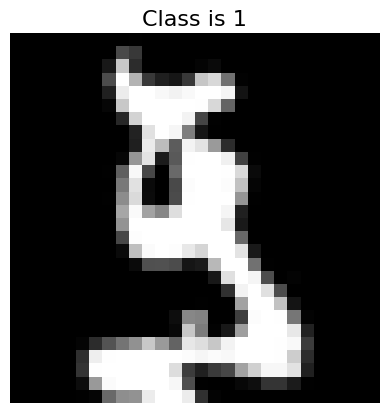

In [4]:
plt.imshow(trainset[8][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[8][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





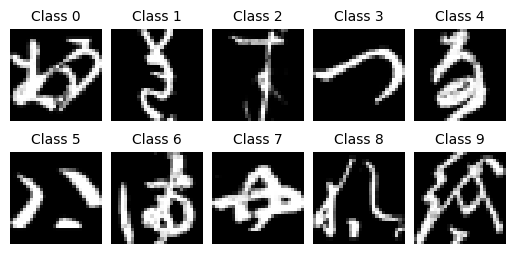

In [5]:
fig, axs = plt.subplots(nrows=2, ncols=5)
for i, ax in zip(range(10), axs.ravel()):
    a = i
    while trainset[a][1] != i:
        a += 1
    ax.imshow(trainset[a][0].view(28, 28).numpy(), cmap="gray")
    ax.axis("off")
    ax.set_title(f"Class {trainset[a][1]}", fontsize=10);
plt.subplots_adjust(wspace=0.1, hspace=-0.5)

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class FCNet(nn.Module):
    def __init__(self, activation = F.relu, last_activation = None):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features = 28*28, out_features = 256) 
        self.fc2 = nn.Linear(in_features = 256, out_features = 128) 
        self.fc3 = nn.Linear(in_features = 128, out_features = 10) 
        
        self.activation = activation # F.relu
        self.last_activation = last_activation
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        logits = self.fc3(x)
        
        # Никита Ваулин был здесь:
        # Насколько я себе это понимаю, активация после последнего слоя - вещь зависящая от задачи.
        # В целом можно было бы докинуть relu, но кажется это будет хорошо только для бинарной классификации.
        # У нас мульти-классовая, вроде как в таком случае можно сделать софт-макс чтобы завернуть все в вероятности.
        # Но базово возвращаем сырые логиты, без активации, так как далее нужны именно они
        if self.last_activation is not None:
            logits = self.last_activation(logits)
        
        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

In [23]:
n_весов = 28*28*256 + 256*128 + 128*10
print(f'{n_весов = }')

n_смещений = 256 + 128 + 10
print(f'{n_смещений = }')

n_параметров = n_весов + n_смещений
print(f'{n_параметров = }')

n_весов = 234752
n_смещений = 394
n_параметров = 235146


### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [14]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [57]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [58]:
# на 10 эпохах все слишком сильно скакало, поднял до 40.
n_epochs = 40
loss_history = []

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))
    if (epoch+1) % 10 == 0:
        print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=10 loss=0.1074
Epoch=20 loss=0.0236
Epoch=30 loss=0.0035
Epoch=40 loss=0.0006


In [59]:
get_accuracy(fc_net, testloader)

0.9052

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [60]:
mean = torch.mean(next(iter(trainloader))[0]) ## calculate mean
std = torch.std(next(iter(trainloader))[0]) ## calculate std
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

tensor(0.1284) tensor(0.3466)


In [61]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [62]:
n_epochs = 40
loss_history = []

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))
    if (epoch+1) % 10 == 0:
        print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=10 loss=0.0468
Epoch=20 loss=0.0034
Epoch=30 loss=0.0005
Epoch=40 loss=0.0001


In [63]:
get_accuracy(fc_net, testloader)

0.9065

Как изменилась `accuracy` после нормализации?

> За время пути собачка немного смогла подрасти

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [64]:
## YOUR CODE HERE

In [66]:
activations = [nn.ReLU(), nn.Sigmoid(), nn.GELU(), nn.Tanh()]

lr = 0.001
n_epochs = 40

for activation in activations:
    print('='*50)
    print(f'{activation = }')
    fc_net = FCNet(activation = activation)
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
    
    loss_history = []
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader: # Получаем батч тренировочных картинок
            optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
            outputs = fc_net(images) # делаем предсказания
            loss = loss_function(outputs, labels) # считаем лосс
            loss.backward() # считаем градиенты
            optimizer.step() # делаем шаг градиентного спуска

            epoch_loss += loss.item()

        loss_history.append(epoch_loss/len(trainloader))
        if (epoch+1) % 10 == 0:
            print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")
    accucary = get_accuracy(fc_net, testloader)
    print(f'{accucary = } \n')

activation = ReLU()
Epoch=10 loss=0.0510
Epoch=20 loss=0.0043
Epoch=30 loss=0.0005
Epoch=40 loss=0.0001
accucary = 0.9056 

activation = Sigmoid()
Epoch=10 loss=0.1870
Epoch=20 loss=0.0559
Epoch=30 loss=0.0133
Epoch=40 loss=0.0029
accucary = 0.8964 

activation = GELU(approximate='none')
Epoch=10 loss=0.0414
Epoch=20 loss=0.0026
Epoch=30 loss=0.0004
Epoch=40 loss=0.0001
accucary = 0.9038 

activation = Tanh()
Epoch=10 loss=0.0317
Epoch=20 loss=0.0017
Epoch=30 loss=0.0003
Epoch=40 loss=0.0001
accucary = 0.9074 



С использованием какой функции активации удалось досчить наибольшей `accuracy`?

> Лучше всего отработала Tanhхушечка

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [69]:
optimisators  = [torch.optim.Adam, torch.optim.Adagrad, torch.optim.RMSprop]
lr = 0.001
n_epochs = 40
best_activation = nn.Tanh()

for optimisator in optimisators:
    print('='*50)
    print(f'{optimisator = }')
    fc_net = FCNet(activation = best_activation)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optimisator(fc_net.parameters(), lr=3e-4)
    
    loss_history = []
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader: # Получаем батч тренировочных картинок
            optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
            outputs = fc_net(images) # делаем предсказания
            loss = loss_function(outputs, labels) # считаем лосс
            loss.backward() # считаем градиенты
            optimizer.step() # делаем шаг градиентного спуска

            epoch_loss += loss.item()

        loss_history.append(epoch_loss/len(trainloader))
        if (epoch+1) % 10 == 0:
            print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")
    accucary = get_accuracy(fc_net, testloader)
    print(f'{accucary = } \n')

optimisator = <class 'torch.optim.adam.Adam'>
Epoch=10 loss=0.0304
Epoch=20 loss=0.0016
Epoch=30 loss=0.0003
Epoch=40 loss=0.0001
accucary = 0.902 

optimisator = <class 'torch.optim.adagrad.Adagrad'>
Epoch=10 loss=0.6555
Epoch=20 loss=0.5623
Epoch=30 loss=0.5128
Epoch=40 loss=0.4779
accucary = 0.7308 

optimisator = <class 'torch.optim.rmsprop.RMSprop'>
Epoch=10 loss=0.0242
Epoch=20 loss=0.0083
Epoch=30 loss=0.0001
Epoch=40 loss=0.0001
accucary = 0.9042 



 > RMSprop показал лучшее качество, хотя Adam тоже не плох. В целом даже на 40 эпохах все не оч устойчиво.

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [71]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x
        x[x < 0] = 0
        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [74]:
fc_net = FCNet(activation = CustomReLU())
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
n_epochs = 40
loss_history = []

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))
    if (epoch+1) % 10 == 0:
        print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=10 loss=0.0511
Epoch=20 loss=0.0039
Epoch=30 loss=0.0005
Epoch=40 loss=0.0001


In [75]:
accucary = get_accuracy(fc_net, testloader)
print(f'{accucary = } \n')

accucary = 0.9026 



> Получил accuracy 0.9026, что не очень далеко от 0.9052 с nn.ReLu. Опять же, у нас еще большой тремор accuracy.

### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

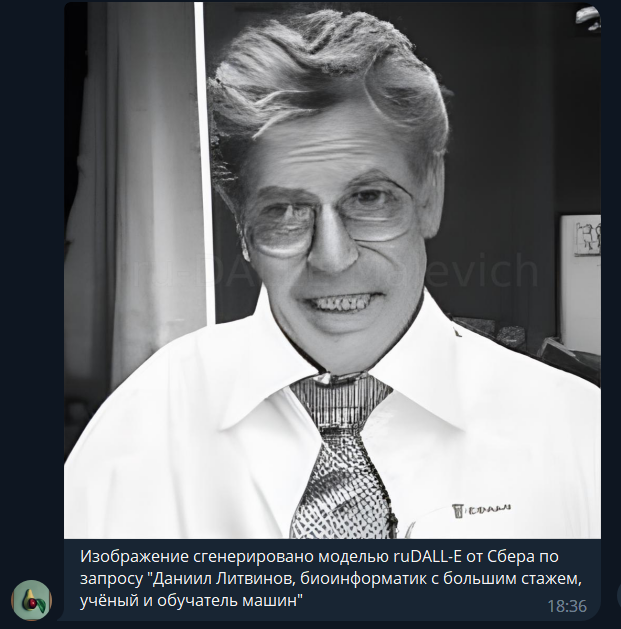

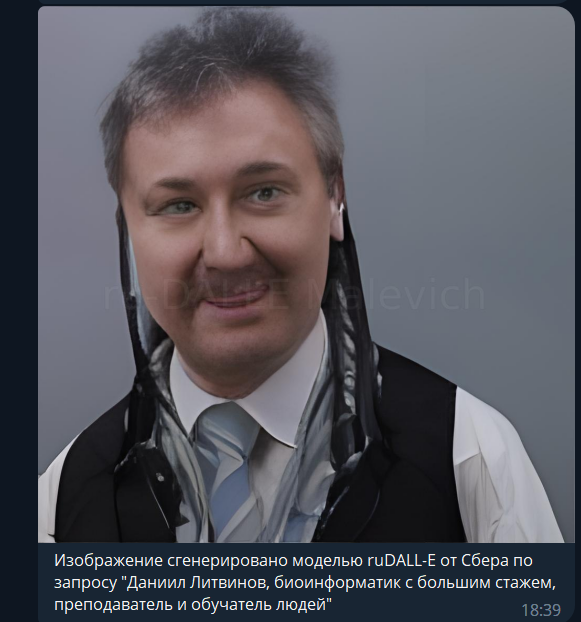

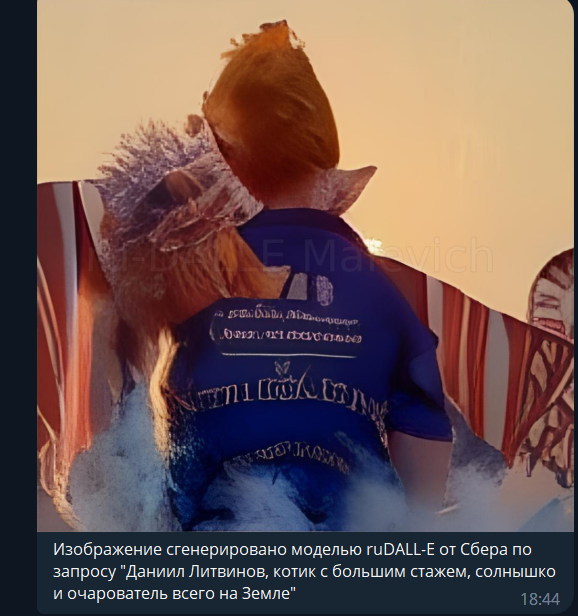